# Cancer Classification

![image](https://storage.googleapis.com/kaggle-datasets-images/3032092/5212576/69196f95972506ae66da827386432a26/dataset-cover.jpg?t=2023-03-23-10-05-44)

## Summary

* [1. Required Libraries and Data](#1)
* [2. Visualizing the Data](#2)
* [3. Data Pre-processing](#3)
* [4. Cancer Classification Model](#4)
* [5. Hyperparameter Tuning](#5)
* [6. Model Evaluation](#6)
* [7. Model Deployment](#7)

## <span id="1"></span>1. Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.pipeline import make_pipeline, Pipeline
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

seed = 11
random.seed(seed)
np.random.seed(seed)

df = pd.read_csv("../input/cancer-data/Cancer_Data.csv", index_col=0).reset_index(drop=True)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

All values from "Unnamed: 32" column are missing, so we will drop it.

In [3]:
df.drop("Unnamed: 32", axis=1, inplace=True)

## <span id="2"></span>2. Visualizing the Data

In [4]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Our dataset is composed by 30 numerical features and the target variable. All the predictor variables are continuous and ranges within different scales, so we need to consider applying feature scaling before using them to train the models.

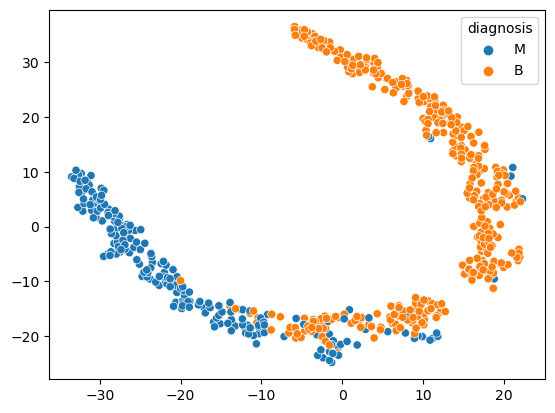

In [5]:
tsne = TSNE(random_state=seed)
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

components = tsne.fit_transform(X)
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=df["diagnosis"])
plt.show()

By the projection of data, we can see that there is a good separation between instances of the two classes and a low number of possible outliers.

Now, let's analyze the correlation between variables of the dataset.

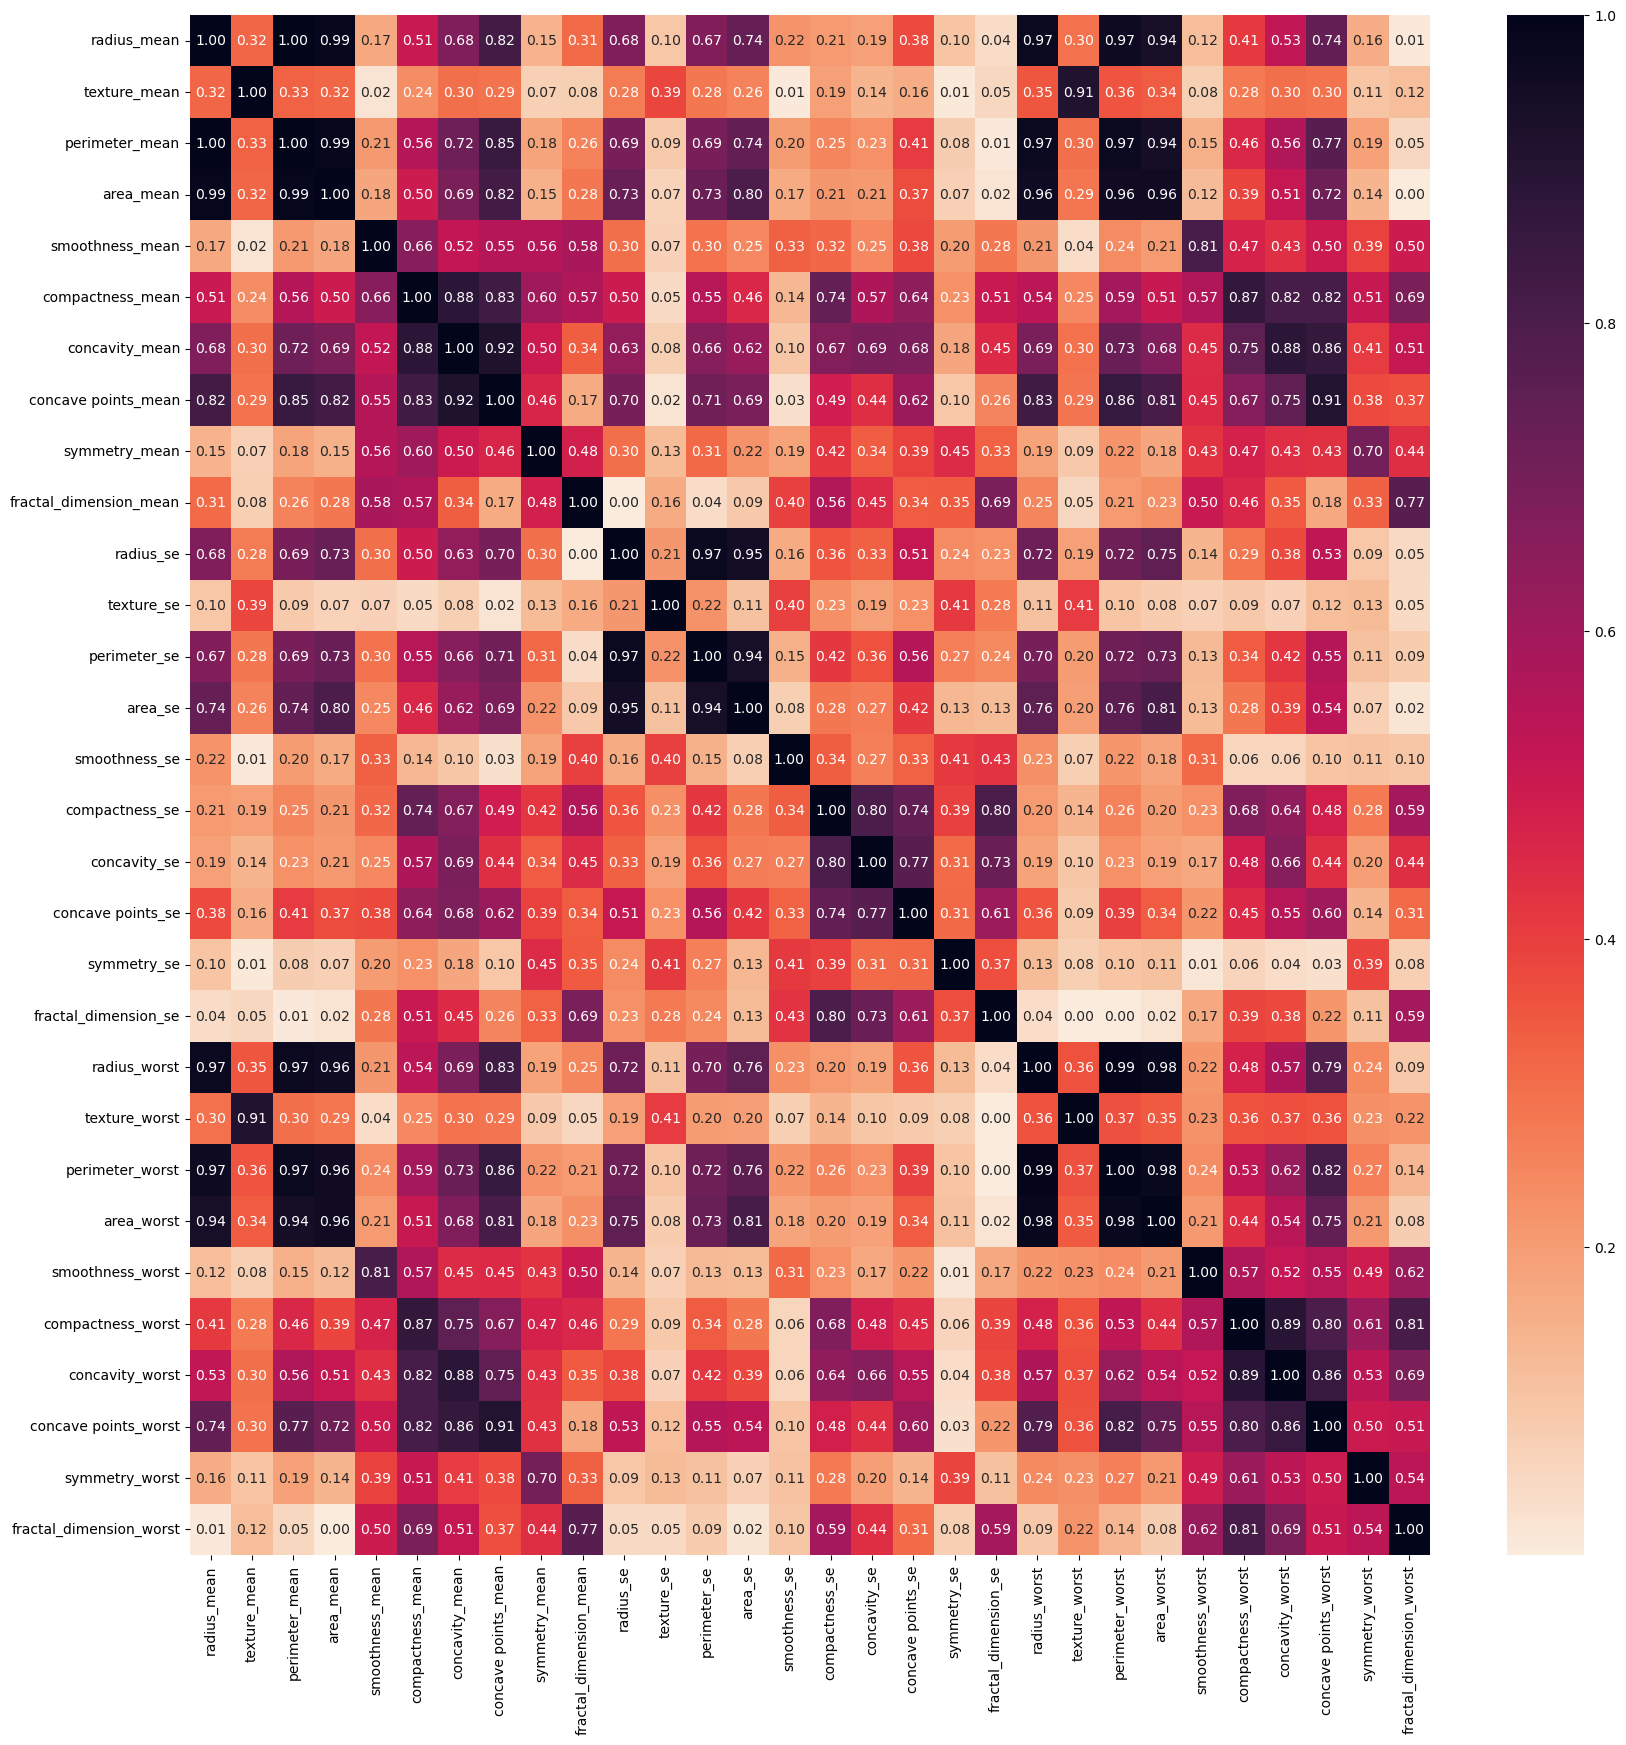

In [6]:
corr = df.corr().abs()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap="rocket_r", cbar=True, annot=True, fmt=".2f")
plt.show()

From the correlation matrix above, there are a some predictor variables that have high correlation between them. This can negatively impact linear models because of the **multicollinearity** problem, so we will be dealing with it later.

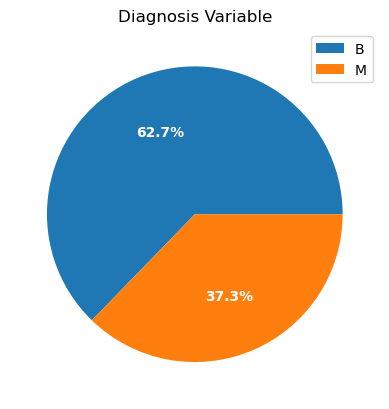

In [7]:
target_counts = df["diagnosis"].value_counts()
plt.title("Diagnosis Variable")
plt.pie(target_counts, labels=target_counts.index, autopct="%1.1f%%", textprops=dict(color="white", weight="bold"))
plt.legend(loc="upper right")
plt.grid(axis="y", alpha=0.2)
plt.show()

Our target variable has more benign than malign cases, but the imbalancement is not extreme, so probably we won't need to do anything about it.

## <span id="3"></span>3. Data Pre-processing

First, let's split our dataset into predictors and predicted variables (X and y).

In [8]:
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

As we saw in the previous sections, our predictor variables ranges within **different scales**. This can cause our model to give unjustified relevance to some features as opposed to anothers. So, to prevent this scenario, we will apply the **z-score transformation** to our input features.

In [9]:
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

The target feature (_diagnosis_) is labeled with values "B" and "M", representing benign and malign cancer, respectively.
To train and evaluate our models, we need to transform its values to a numerical type, so let's encode it with values **0** (benign) and **1** (malign) with the LabelEncoder provided by _sklearn_.

In [10]:
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
encoder.classes_

array(['B', 'M'], dtype=object)

Now, let's split our transformed data into 80% for training and 20% for testing.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_enc, test_size=0.2, shuffle=True)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (455, 30)
X_test: (114, 30)


## <span id="4"></span>4. Cancer Classification Model

### <span id="4-1"></span>4.1. Baseline

The first thing we will be doing is define a simple model as our baseline. It will serve as reference to compare performances between more complex models in the classification task. The model we will be using is the LogisticRegression.

In [12]:
model = LogisticRegression(random_state=seed)
scores = cross_val_score(
    model,
    X_train,
    y_train,
    scoring="accuracy",
    cv=ShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
)

print(f"Accuracy Score: {np.round(np.mean(scores), 3)} ± {np.round(np.std(scores), 3)}")

Accuracy Score: 0.978 ± 0.012


As we can see, our baseline model has a good performance, with mean accuracy score of 97,8%.
Now we will try to improve the LogistRegression performance applying the Principal Component Analysis technique to reduce data dimensionality.

In [13]:
pca = PCA(n_components=15, random_state=seed)
X_train_t = pca.fit_transform(X_train)
X_test_t = pca.transform(X_test)

model = LogisticRegression(random_state=seed)
scores = cross_val_score(
    model,
    X_train_t,
    y_train,
    scoring="accuracy",
    cv=ShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
)

print(f"Accuracy Score: {np.round(np.mean(scores), 3)} ± {np.round(np.std(scores), 3)}")

Accuracy Score: 0.981 ± 0.01


The application of PCA resulted in a model with better accuracy, so we will use the PCA technique in the final estimator to perform the classifications.

## <span id="5"></span>5. Hyperparameter Tuning

In [14]:
model = make_pipeline(
    PCA(random_state=seed),
    LogisticRegression(random_state=seed)
)

cv = GridSearchCV(
    model,
    {
        "pca__n_components": np.arange(2, 25),
        "logisticregression__C": [0.01, 0.1, 0.5, 1, 5, 10]
    },
    scoring="accuracy",
    cv=ShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
).fit(X_train, y_train)

In [15]:
print(cv.best_estimator_)
print(f"Accuracy Score: {np.round(cv.best_score_, 3)}")

Pipeline(steps=[('pca', PCA(n_components=13, random_state=11)),
                ('logisticregression',
                 LogisticRegression(C=1, random_state=11))])
Accuracy Score: 0.981


## <span id="6"></span>6. Model Evaluation

In [16]:
def metrics(y_true, y_pred):
    acc = np.round(accuracy_score(y_true, y_pred), 3)
    auc = np.round(roc_auc_score(y_true, y_pred), 3)
    precision = np.round(precision_score(y_true, y_pred), 3)
    recall = np.round(recall_score(y_true, y_pred), 3)
    
    return pd.DataFrame(
        data={
            "Accuracy": [acc],
            "ROC AUC": [auc],
            "Precision": [precision],
            "Recall": [recall]
        }
    )

In [17]:
y_pred = cv.best_estimator_.predict(X_test)

metrics(y_test, y_pred)

,Accuracy,ROC AUC,Precision,Recall
0,0.982,0.98,0.974,0.974


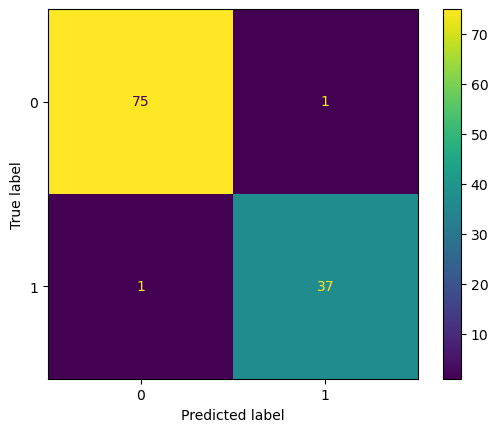

In [18]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

## <span id="7"></span>7. Model Deployment

In [19]:
X = df.drop("diagnosis", axis=1).values
y = df["diagnosis"].values

In [20]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=13, random_state=seed)),
    ("estimator", LogisticRegression(C=1, random_state=seed))
])

pipe.fit(X, y)

joblib.dump(pipe, "model.joblib")

['model.joblib']